## Cancer Image Identification
* In this notebook we evaluate the Cancer Detection Dataset on Kaggle
* This notebook is availble at https://github.com/wiwi9262/cancer_detection  **GITHUB REPOSITORY**

### Problem Statement
* The PCAM dataset includes images that allow us to train a model for identifying metastatic cancer
* Creating labels for images is not a linearly seperable problem
* Convolutional Neural Networks have been shown to provide good results for labeling images
* The dataset is a subset of the orginal dataset that has had duplicates removed
* The problem is important because it can help with automatically labeling the probability that an image contains cancer
* This helps physicians and researches with screening; even if they do not solely rely on automated labeling
* Source : https://www.kaggle.com/c/histopathologic-cancer-detection

### Imports

In [74]:
from PIL import Image
from os import listdir
from os.path import isfile, join,splitext
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

#from sklearn.model_selection import train_test_split


### Download the Data

In [2]:
# This will download the data and locally store it
# There are more than 7 GB of images files
# This assumes that the kaggle API is installed - pip install kaggle
## and that the api key is downloaded 


# Only run once
# ! kaggle competitions download -c histopathologic-cancer-detection

In [3]:
# Unzip the file

"""
import zipfile
path_to_zip_file = "data/histopathologic-cancer-detection.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("images")
"""


'\nimport zipfile\npath_to_zip_file = "data/histopathologic-cancer-detection.zip"\nwith zipfile.ZipFile(path_to_zip_file, \'r\') as zip_ref:\n    zip_ref.extractall("images")\n'

### Describe the Data
* Brief description of the challenge problem and NLP. Description of the size, dimension, structure of the data
    * Identifying cancer is a difficult process that requires an expert to evaluate images
    * Machine learning can assist the experts by labeling images with a belief metric related to the probability that the image includes malignant cells
    * The purpose of this exercise is to train a nueral network on a model that includes data labeled as either 0 or 1
    * A label of 1 means that it contains a malignant cell in the center block of the data
    * The data is presented as 96x96 pixels with 3 colors
    * There are 220,025 traininig images
    * Out of those images, 89117 include a malignant cell
    * Since approximately 40% of the data was labeled as malignant, that is balanced enough to not need upsampling
    * The test set contains 57,458 records of unknown labels


In [5]:
training_labels = pd.read_csv("./images/train_labels.csv")
training_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
training_labels.sort_values(by=['id'],ascending=True,inplace=True)

In [7]:
training_labels.head(10)

,id,label
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
16166,000020de2aa6193f4c160e398a8edea95b1da598,0
87832,00004aab08381d25d315384d646f5ce413ea24b1,0
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
128953,0000da768d06b879e5754c43e2298ce48726f722,1
95060,0000f8a4da4c286eee5cf1b0d2ab82f979989f7b,0
134354,00010f78ea8f878117500c445a658e5857f4e304,0
52564,00011545a495817817c6943583b294c900a137b8,0
78234,000126ec42770c7568204e2f6e07eb9a07d5e121,0
90027,00014e39b5df5f80df56f18a0a049d1cc6de430a,1


In [8]:
label_list = list(training_labels['label'])

In [9]:
file ="00014e39b5df5f80df56f18a0a049d1cc6de430a"
int(training_labels['label'][training_labels['id']==file] )

1

In [10]:
label_list[0:10]  # Just spot checking

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]

In [11]:
# Sort the images and save as PNG
# I am doing this so it works nicely with the keras util to load images from a diretory
# I commented it out after the initial run so I could easily restart the notebook
comment_out = """
mypath = "./images/train/"
dst_path = "./images/label_subfolder/train/" # manually created
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for the_file in onlyfiles:
    if "tif" in the_file:
        with Image.open(mypath+the_file) as im:
            file, ext = splitext(the_file)
            #try:
            if int(training_labels['label'][training_labels['id']==file]) == 0:
                    im.save(dst_path+ "0/" +file + ".png","PNG")
            else:
                    im.save(dst_path+ "1/" +file + ".png","PNG")
            #except:
            #    print("Skipped",file)
            
"""            

In [12]:

comment_out = """
mypath = "./images/test/"
dst_path = "./images/test_png/" # manually created
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for the_file in onlyfiles:
    if "tif" in the_file:
        with Image.open(mypath+the_file) as im:
            file, ext = splitext(the_file)
            im.save(dst_path+file + ".png","PNG")
"""


In [13]:
# ?tf.keras.utils.image_dataset_from_directory

In [14]:
mypath = "./images/label_subfolder/train"

In [15]:
# Get random seed for split
seed= random.randint(1,10000)

In [16]:
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mypath,
  label_mode = 'binary',
  validation_split=0.7,
  subset="training",
  seed=seed,
  image_size=(96, 96),
  batch_size=batch_size
)

# if this doesnt work then write a sorting function

Found 220025 files belonging to 2 classes.
Using 66008 files for training.


2022-05-31 00:32:42.722802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-05-31 00:32:42.722886: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 00:32:42.722922: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-ann): /proc/driver/nvidia/version does not exist
2022-05-31 00:32:42.723457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
batch_size=32
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mypath,
  label_mode = 'binary',
  validation_split=0.3,
  subset="validation",
  seed=seed,
  image_size=(96, 96),
  batch_size=batch_size
)

# if this doesnt work then write a sorting function

Found 220025 files belonging to 2 classes.
Using 66007 files for validation.


In [18]:
train_ds.class_names

['0', '1']

### Exploratory Data Analysis
* Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 
    * The data is fairly clean already
    * It contains 40% maligant and 60% benign images
    * All images are 96x96x3 images
        * We only care about finding a cell in the center 32x32
        * The other pixels are included to help with padding
    * To load the data, we used a Keras library to load images from a directory
    * This library handled batching, but it does not support TIFF
    * To get out data to work with this library, we used PIL to convert to PNG
    * The library supports a label file, but it was not working properly
    * To work around the issue, we sorted the data by label into folders called "0" and "1"
    * The sorting mitigated the problem with the Keras load data method
    * Pixel values range up to 255. We need to scale that to range from 0 1 for the CANN to operate
        * Scaling is supported as a layer in the CNN

#### Two example benign images


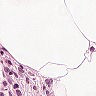

In [117]:
pil_im = Image.open('images/label_subfolder/train/0/f38a6374c348f90b587e046aac6079959adf3835.png')
display(pil_im)
pil_im.close()

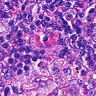

In [118]:
pil_im = Image.open('images/label_subfolder/train/0/79d7929dc47230f323e439fba10afb21bc906356.png')
display(pil_im)
pil_im.close()

#### Two sample malignant images

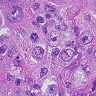

In [119]:
pil_im = Image.open('images/label_subfolder/train/1/a1a9e9c1282bcbe4208fa8daad935d6771af9792.png')
display(pil_im)
pil_im.close()

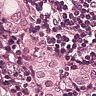

In [120]:
pil_im = Image.open('images/label_subfolder/train/1/bcf56e8dc7668c6f2aabd4cba9517a5b5d1439ca.png')
display(pil_im)
pil_im.close()

#### Two sample test images

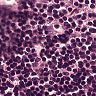

In [121]:
pil_im = Image.open('images/test_png/0084317dbb3398aed9f7c915c2cdef5a07ada5be.png')
display(pil_im)
pil_im.close()

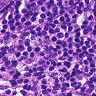

In [122]:
pil_im = Image.open('images/test_png/cb61efc7ad4f45c2989b8338aae9a8a578102a6c.png')
display(pil_im)
pil_im.close()

* Not being a medical professional, I do not even know where to start but I will demonstrate that a CNN can figure it out

#### Histogram of label distribution

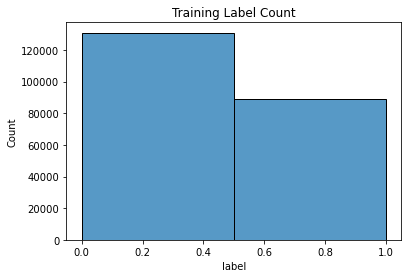

In [115]:
sns.histplot(data=training_labels, x="label",bins=2).set(title='Training Label Count');

### Model Architecture
* Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 


#### Model 1
* We started with a model that includes a rescaling layer then alternates between convolution and max pooling layers
* We used the default stride and rectified linear unit activation
* We did not flatten before the first layer
* We used two layers in the back propigaton part with 64 nodes in the hidden layer
* We used early stopping with a patience setting of 2
    * The patience setting was added after initial testing to prevent undertraining problems that I was seeing

In [59]:
model1 = models.Sequential()
model1.add(layers.Rescaling(1./255))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [64]:
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(1,activation='sigmoid'))

In [69]:
model1.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [70]:
# simple early stopping
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
es1 = EarlyStopping(monitor='val_loss', mode='auto', patience=2, verbose=1)
image_fit1 = model1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10, 
                      callbacks=[es1]
                   )

Epoch 1/10
2063/2063 [==============================] - 654s 316ms/step - loss: 0.4708 - accuracy: 0.7809 - val_loss: 0.4271 - val_accuracy: 0.8045
Epoch 2/10
2063/2063 [==============================] - 636s 308ms/step - loss: 0.4034 - accuracy: 0.8219 - val_loss: 0.3966 - val_accuracy: 0.8252
Epoch 3/10
2063/2063 [==============================] - 642s 311ms/step - loss: 0.3463 - accuracy: 0.8513 - val_loss: 0.3336 - val_accuracy: 0.8558
Epoch 4/10
2063/2063 [==============================] - 654s 317ms/step - loss: 0.3030 - accuracy: 0.8731 - val_loss: 0.3526 - val_accuracy: 0.8487
Epoch 5/10
2063/2063 [==============================] - 653s 316ms/step - loss: 0.2591 - accuracy: 0.8951 - val_loss: 0.3681 - val_accuracy: 0.8547
Epoch 5: early stopping


Train: 0.905, Validation: 0.855


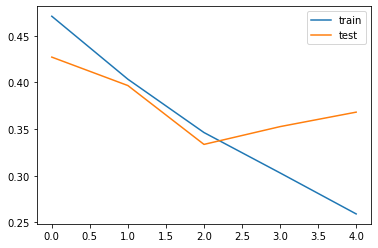

In [71]:
# evaluate the model
_, train_acc1 = model1.evaluate(train_ds, verbose=0)
_, test_acc1 = model1.evaluate(val_ds, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc1, test_acc1))
# plot training history
plt.plot(image_fit1.history['loss'], label='train')
plt.plot(image_fit1.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Model 2
* Model 2 is the same as model 1 except we 
    * Removed a max pool and added a stride to one convolution layer
    * Change kernel size to 5x5


In [30]:
model2 = models.Sequential()
model2.add(layers.Rescaling(1./255))
model2.add(layers.Conv2D(32, (5, 5), activation='relu',padding="same",strides=(2,2), input_shape=(96, 96, 3)))
model2.add(layers.Conv2D(64, (5, 5), activation='relu',padding="same"))
model2.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))
model2.add(layers.Conv2D(64, (5, 5), activation='relu',padding="same"))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(1, activation="sigmoid")) 
model2.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])

In [31]:
es2 = EarlyStopping(monitor='val_loss', mode='auto', patience=2, verbose=1)
image_fit2 = model2.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10, 
                      callbacks=[es2]
                   )

Epoch 1/10
2063/2063 [==============================] - 1263s 612ms/step - loss: 0.4774 - accuracy: 0.7778 - val_loss: 0.4063 - val_accuracy: 0.8144
Epoch 2/10
2063/2063 [==============================] - 1259s 611ms/step - loss: 0.3921 - accuracy: 0.8237 - val_loss: 0.3700 - val_accuracy: 0.8315
Epoch 3/10
2063/2063 [==============================] - 1258s 610ms/step - loss: 0.3570 - accuracy: 0.8429 - val_loss: 0.3449 - val_accuracy: 0.8457
Epoch 4/10
2063/2063 [==============================] - 1260s 611ms/step - loss: 0.3294 - accuracy: 0.8571 - val_loss: 0.3383 - val_accuracy: 0.8526
Epoch 5/10
2063/2063 [==============================] - 1278s 619ms/step - loss: 0.2883 - accuracy: 0.8786 - val_loss: 0.3504 - val_accuracy: 0.8488
Epoch 6/10
2063/2063 [==============================] - 1260s 611ms/step - loss: 0.2371 - accuracy: 0.9020 - val_loss: 0.3994 - val_accuracy: 0.8439
Epoch 6: early stopping


Train: 0.913, Validation: 0.844


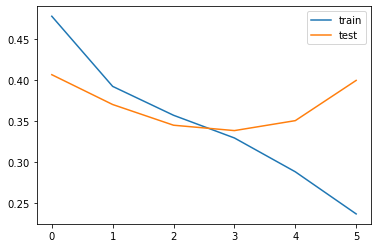

In [32]:
# evaluate the model
_, train_acc2 = model2.evaluate(train_ds, verbose=0)
_, test_acc2 = model2.evaluate(val_ds, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc2, test_acc2))
# plot training history
plt.plot(image_fit2.history['loss'], label='train')
plt.plot(image_fit2.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Model 3
* Model 3 is the same as model 2 except we 
    * Added more strides
    * Removed all pooling


In [33]:
model3 = models.Sequential()
model3.add(layers.Rescaling(1./255))
model3.add(layers.Conv2D(32, (6,6), activation='relu',padding="same",strides=(3,3), input_shape=(96, 96, 3)))
model3.add(layers.Conv2D(64, (6, 6), activation='relu',strides=(3,3),padding="same"))
#model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Conv2D(64, (6, 6), activation='relu',strides=(3,3),padding="same"))
model3.add(layers.Flatten())
model3.add(layers.Dense(32, activation="relu"))
model3.add(layers.Dense(1, activation="sigmoid")) 
model3.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])

In [34]:
es3 = EarlyStopping(monitor='val_loss', mode='auto', patience=2, verbose=1)
image_fit3 = model3.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10, 
                      callbacks=[es3]
                   )

Epoch 1/10
2063/2063 [==============================] - 157s 76ms/step - loss: 0.4869 - accuracy: 0.7714 - val_loss: 0.4298 - val_accuracy: 0.8078
Epoch 2/10
2063/2063 [==============================] - 158s 76ms/step - loss: 0.4254 - accuracy: 0.8071 - val_loss: 0.4189 - val_accuracy: 0.8094
Epoch 3/10
2063/2063 [==============================] - 158s 76ms/step - loss: 0.3921 - accuracy: 0.8270 - val_loss: 0.3896 - val_accuracy: 0.8288
Epoch 4/10
2063/2063 [==============================] - 157s 76ms/step - loss: 0.3600 - accuracy: 0.8426 - val_loss: 0.4197 - val_accuracy: 0.8105
Epoch 5/10
2063/2063 [==============================] - 157s 76ms/step - loss: 0.3084 - accuracy: 0.8684 - val_loss: 0.4518 - val_accuracy: 0.8071
Epoch 5: early stopping


Train: 0.912, Validation: 0.846


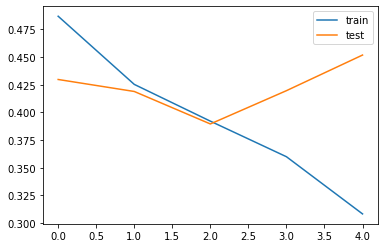

In [35]:
# evaluate the model
_, train_acc3 = model3.evaluate(train_ds, verbose=0)
_, test_acc3 = model3.evaluate(val_ds, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc1, test_acc1))
# plot training history
plt.plot(image_fit3.history['loss'], label='train')
plt.plot(image_fit3.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Model 4
* Model 4 is the same as model 3 except we add  a drop out layer


In [36]:
model4 = models.Sequential()
model4.add(layers.Rescaling(1./255))
model4.add(layers.Conv2D(32, (6,6), activation='relu',padding="same",strides=(3,3), input_shape=(96, 96, 3)))
model4.add(layers.Conv2D(64, (6, 6), activation='relu',strides=(3,3),padding="same"))
model4.add(layers.Conv2D(64, (6, 6), activation='relu',strides=(3,3),padding="same"))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.2, (None, 1024) ))
model4.add(layers.Dense(32, activation="relu"))
model4.add(layers.Dense(1, activation="sigmoid")) 
model4.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])

In [37]:
es4 = EarlyStopping(monitor='val_loss', mode='auto', patience=2, verbose=1)
image_fit4 = model4.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10, 
                      callbacks=[es4]
                   )

Epoch 1/10
2063/2063 [==============================] - 160s 77ms/step - loss: 0.5012 - accuracy: 0.7606 - val_loss: 0.4594 - val_accuracy: 0.7881
Epoch 2/10
2063/2063 [==============================] - 157s 76ms/step - loss: 0.4524 - accuracy: 0.7943 - val_loss: 0.4379 - val_accuracy: 0.8001
Epoch 3/10
2063/2063 [==============================] - 153s 74ms/step - loss: 0.4270 - accuracy: 0.8091 - val_loss: 0.4200 - val_accuracy: 0.8121
Epoch 4/10
2063/2063 [==============================] - 153s 74ms/step - loss: 0.3999 - accuracy: 0.8223 - val_loss: 0.4281 - val_accuracy: 0.8074
Epoch 5/10
2063/2063 [==============================] - 153s 74ms/step - loss: 0.3678 - accuracy: 0.8382 - val_loss: 0.4355 - val_accuracy: 0.8089
Epoch 5: early stopping


Train: 0.865, Validation: 0.809


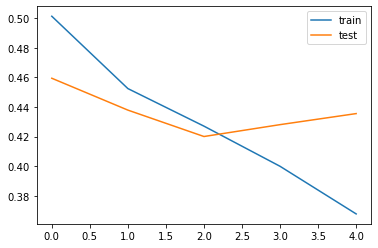

In [38]:
# evaluate the model
_, train_acc4 = model4.evaluate(train_ds, verbose=0)
_, test_acc4 = model4.evaluate(val_ds, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc4, test_acc4))
# plot training history
plt.plot(image_fit4.history['loss'], label='train')
plt.plot(image_fit4.history['val_loss'], label='test')
plt.legend()
plt.show()

### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.


* I tested several options that are not documented in this document
* Some models got stuck at an accuracy of approximately 60% which aligns with the proportion of benign images
* These models seemed to "train" slowly but did not improve no mater how many epochs I allowed
* One example is when I had two convolution layers using the default stride setting and without any pooling between the layers
* The first model used Max Pooling between each convolution layer. That had good results.
* We also tried strides and different filter sizes.
* The accuracy of the four models in this notebook are similar, but the training times differ
* The first model was the fastest
* The second model was the slowest
* The third and fourth models were adjustments to the second model to improve the speed
* Tables of results are provided in the conclusion section

### Save CSV file for scoring on Kaggle

In [75]:
# I am not sure if order matters. Just in case, lets load the CSV. 
# Find the file associated with the name and test it then update the CSV
dfResult1 = pd.read_csv("images/sample_submission.csv")
dfResult2 = dfResult1.copy()
dfResult3 = dfResult1.copy()
dfResult4 = dfResult1.copy()

In [98]:
mypath = "./images/test_png"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mypath,
  labels=None,
  shuffle = False, # I think this was my problem. Defaults to shuffle=True
  label_mode = 'binary',
  image_size=(96, 96)
)

Found 57458 files belonging to 1 classes.


In [99]:
# Take a look at the dataset to see if I can figure out proper way to use it with predict
test_labels1 = model1.predict(test_ds)
test_labels2 = model2.predict(test_ds)
test_labels3 = model3.predict(test_ds)
test_labels4 = model4.predict(test_ds)

1796/1796 [==============================] - 41s 23ms/step


In [100]:
test_labels2

array([[8.4114689e-01],
       [9.8265105e-01],
       [7.3275220e-01],
       ...,
       [3.0504028e-09],
       [8.0031246e-01],
       [1.8986596e-02]], dtype=float32)

In [101]:
file_paths = test_ds.file_paths
#file_list = [splitext(x)[0] for x in file_paths]
file_list = [x[18:-4] for x in file_paths]


In [103]:
for index in range(len(file_list)):
    dfResult1.loc[dfResult1['id'] == file_list[index],'label'] = round(test_labels1[index,0])
    dfResult2.loc[dfResult2['id'] == file_list[index],'label'] = round(test_labels2[index,0])
    dfResult3.loc[dfResult3['id'] == file_list[index],'label'] = round(test_labels3[index,0])
    dfResult4.loc[dfResult4['id'] == file_list[index],'label'] = round(test_labels4[index,0])


In [104]:
dfResult3.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [105]:
dfResult1['label'].sum()
# this had things that werent 0 but it was still 50% detection. something is wrong 
# I think the problem is in how it is reading the test data.


19275

In [106]:
dfResult2['label'].sum()

20517

In [107]:
dfResult3['label'].sum()

19526

In [108]:
dfResult4['label'].sum()

20217

In [109]:
dfResult1.to_csv("submission1.csv",index=False)

In [110]:
dfResult2.to_csv("submission2.csv",index=False)

In [111]:
dfResult3.to_csv("submission3.csv",index=False)

In [112]:
dfResult4.to_csv("submission4.csv",index=False)

### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

|Model|Training Accuracy|Training Validation|Test Score|Test Public Score|
|-|-|-|-|-|
|1 | 0.8951 | 0.8547 | 0.7621 | 0.7919|
|2 | 0.9020 | 0.8439 | 0.7791 | 0.7918|
| 3 | 0.8684 | 0.8071 | 0.7316 | 0.7802|
|4 | 0.8382 | 0.8089 | 0.7562 | 0.8041|


* The above table shows the results from each model
* The first model was the most basic and it trained the fastest
* The second model took significantly more time to train but did not provide substantially better results
* Attempts to use concepts from the second model but reduce training time took an impact on results
* Deeper convolutional neural networks could improve the results, but they take a long time to train
    * Due to time constaints, we limited our evaluation to models that could train within a day
    * We implemented early stop, both to reduce training time and to prevent overfitting

### References
* https://arxiv.org/pdf/2108.13661.pdf
* https://www.tensorflow.org/tutorials/load_data/images
* https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
* https://stackoverflow.com/questions/62166588/how-to-obtain-filenames-during-prediction-while-using-tf-keras-preprocessing-ima